# MAGIC

In this notebook, we use molecular cross-validation to find the optimal set of hyperparameters for the MAGIC algorithm on a dataset from

*David van Dijk, et al. Recovering Gene Interactions from Single-Cell Data Using Data Diffusion. 2018. Cell.*

We find that the optimal parameters produce a much less smooth picture of the relationship between three genes, *CDH1, VIM, ZEB1* than the default parameters do, indicating the importance of calibrating denoising methods.

In [1]:
import pathlib
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

from sklearn.metrics import mean_squared_error
from sklearn.utils.extmath import randomized_svd

import magic

import noise2self_sc.util as ut

In [2]:
# load in the EMT dataset
with open("../../data/EMT/dataset_0.pickle", "rb") as f:
    exp_means, umi_counts, umis = pickle.load(f)
    
median_count = np.median(umis.sum(axis=1))

# genes of interest
genes = ['VIM', 'CDH1', 'ZEB1']
genes_i = [17249, 2551, 17678]

When no diffusion is performed (t = 0 and/or k = 0), MAGIC is equivalent to PCA. The `magic` package doesn't allow zero values so we calculated this using the PCA script.

In [3]:
pca_file = pathlib.Path("../../results/EMT_pca_mse_0.pickle")

if pca_file.exists():
    with pca_file.open("rb") as f:
        pca_rec, pca_mcv = pickle.load(f)
else:
    pca_rec = dict()
    pca_mcv = dict()

    for i in range(10):
        umis_X, umis_Y = ut.split_molecules(umis, 0.9, 0.0)

        umis_X = umis_X / umis_X.sum(axis=1, keepdims=True) * median_count
        umis_Y = umis_Y / umis_Y.sum(axis=1, keepdims=True) * median_count

        U, S, V = randomized_svd(umis_X, n_components=50)
        US = U.dot(np.diag(S))

        for n_pcs in range(10, 51, 5):
            pca_X = np.maximum(US[:, :n_pcs].dot(V[:n_pcs,:]), 0)

            pca_rec[i, n_pcs, 0, 0] = mean_squared_error(pca_X[:, genes_i], umis_X[:, genes_i])
            pca_mcv[i, n_pcs, 0, 0] = mean_squared_error(pca_X[:, genes_i], umis_Y[:, genes_i])

    with pca_file.open("wb") as out:
        pickle.dump((pca_rec, pca_mcv), out)


In [4]:
results = []

with open("../../results/EMT_magic_mse_0.pickle", "rb") as f:
    res = pickle.load(f)
    
    results.extend(
        {
            'seed': i, 'n_pcs': n, 'k': k, 't': t,
            'rec_loss': res['rec_loss'][i,n,k,t],
            'mcv_loss': res['mcv_loss'][i,n,k,t],
        }
        for i,n,k,t in sorted(res['rec_loss'])
    )

for i,n,k,t in pca_rec:
    if n >= 10 and n % 5 == 0:
        results.append(
            {
                'seed': i, 'n_pcs': n, 'k': k, 't': t,
                'rec_loss': pca_rec[i,n,k,t],
                'mcv_loss': pca_mcv[i,n,k,t],
            }
        )


df = pd.DataFrame(results)

df = df.groupby(["n_pcs", "k", "t"]).mean()
df = df.reset_index()

In [5]:
pc_range = sorted(set(df["n_pcs"]))
k_range = sorted(set(df["k"]))
t_range = sorted(set(df['t']))

print(pc_range, k_range, t_range, sep="\n")

[10, 15, 20, 25, 30, 35, 40, 45, 50]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 2, 3, 4, 5]


The best-performing hyperparameters for MAGIC:

In [6]:
opt_idx = df['mcv_loss'].idxmin()

df.loc[opt_idx][['k', 'n_pcs', 't', 'mcv_loss']]

k            1.000000
n_pcs       30.000000
t            1.000000
mcv_loss    54.260819
Name: 205, dtype: float64

In [7]:
scaled_umis = umis / umis.sum(1, keepdims=True) * median_count

# MAGIC with defult parameters
default_denoised = magic.MAGIC(verbose=0).fit_transform(scaled_umis, genes=genes_i)
default_denoised = np.maximum(default_denoised, 0)

In [8]:
# MAGIC with parameters selected via grid search and MCV loss

k, n_pcs, t = df.loc[opt_idx][['k', 'n_pcs', 't']]

magic_op = magic.MAGIC(verbose=0, n_pca=int(n_pcs))
magic_op.set_params(knn=int(k), t=int(t))

opt_denoised = magic_op.fit_transform(scaled_umis, genes=genes_i)
opt_denoised = np.maximum(opt_denoised, 0)

We tune three hyperparameters of the MAGIC method:
    
1. The number of principal components used
2. The number of neighbors to use in constructing the graph
3. The diffusion time

Default values:
 * n_pca = 100
 * knn = 10
 * t = 'auto' (set to 7 for our dataset)

Optimal values:
 * n_pca = 30
 * knn = 1
 * t = 1
    
Raw equivalent values:
 * n_pca = max (~5000)
 * knn = 0
 * t = 0

Visualize the results of the hyperparameter sweep.

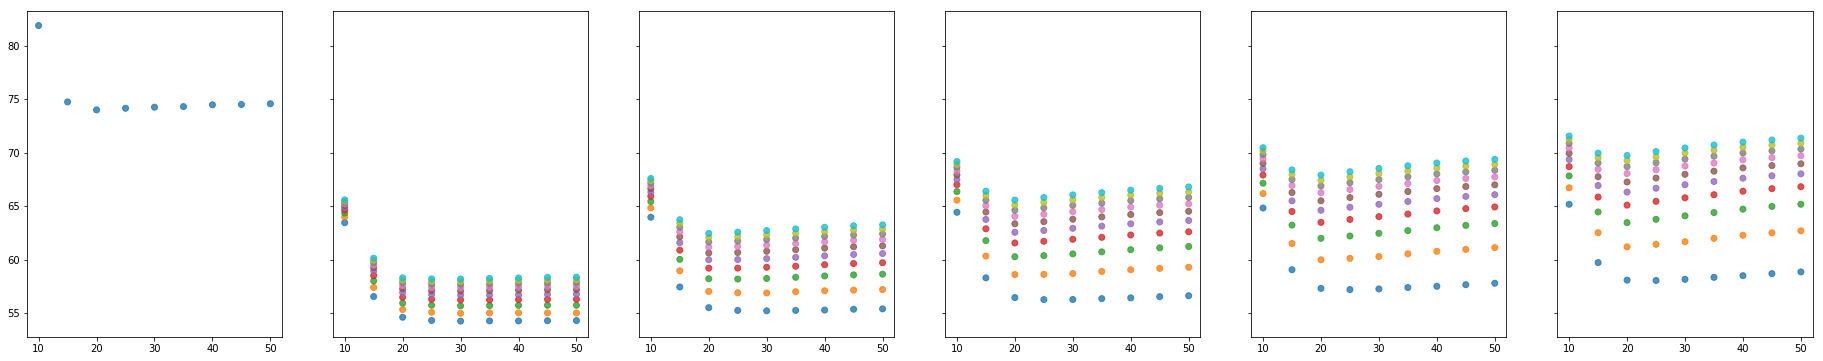

In [9]:
fig,ax = plt.subplots(1, len(t_range), sharey=True, figsize=(32, 6))

for i,t in enumerate(t_range):
    ix = (df["t"] == t)
    ax[i].scatter(df[ix]["n_pcs"], df[ix]["mcv_loss"], c=df[ix]["k"], cmap=plt.cm.tab10, alpha=0.8)

plt.show()

Visualize the curves passing through the best set of parameters.

## Plot

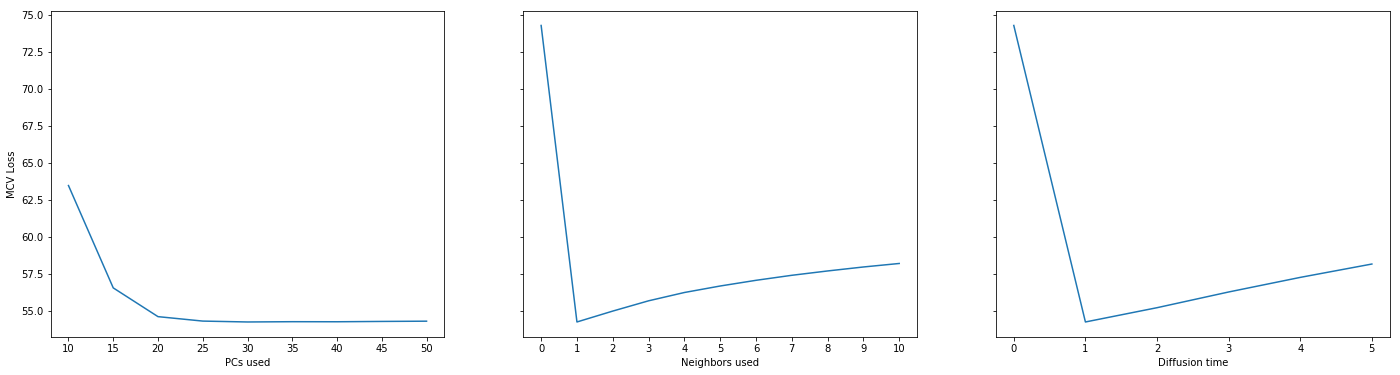

In [10]:
# for each parameter, plot a sweep with the other two are at optimized values

is_opt_n_pcs = (df.n_pcs == df.loc[opt_idx].n_pcs)
is_opt_k = (df.k == df.loc[opt_idx].k)
is_opt_t = (df.t == df.loc[opt_idx].t)
is_pca = (df.t == 0)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(24, 6))
ax[0].plot(df.loc[is_opt_k & is_opt_t].n_pcs, df.loc[is_opt_k & is_opt_t].mcv_loss)
ax[0].set_ylabel('MCV Loss')
ax[0].set_xlabel('PCs used')
ax[0].set_xticks(pc_range)

ax[1].plot(df.loc[is_opt_n_pcs & (is_pca | is_opt_t)].k, df.loc[is_opt_n_pcs & (is_pca | is_opt_t)].mcv_loss)
ax[1].set_xlabel('Neighbors used')
ax[1].set_xticks(k_range)

ax[2].plot(df.loc[(is_pca | is_opt_k) & is_opt_n_pcs].t, df.loc[(is_pca | is_opt_k) & is_opt_n_pcs].mcv_loss)
ax[2].set_xlabel('Diffusion time')
ax[2].set_xticks(t_range)

plt.savefig('../figures/Figure_3_sweep.svg')

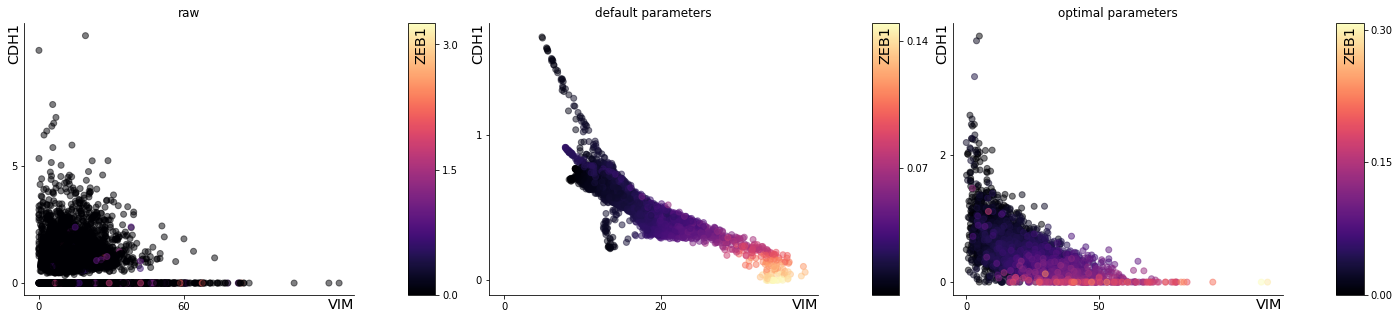

In [11]:
def plot_genes(arrays, titles, xticks, yticks, cbar_ticks):
    fig,ax = plt.subplots(
        1, len(arrays) * 2,
        sharex=False,
        sharey=False,
        figsize=(24, 5),
        gridspec_kw={'width_ratios': [12, 1] * len(arrays), 'wspace': 0.3},
    )

    # sort by z gene to bring highest cells to top of plot
    ix = np.argsort(arrays[2][:,2])

    cmap = plt.get_cmap('magma')
    for i,umis in enumerate(arrays):
        norm = plt.Normalize(umis[:,2].min(), umis[:,2].max())

        ax[2*i].scatter(
            umis[ix,0], umis[ix,1], 
            c = umis[ix,2],
            cmap=cmap, 
            norm=norm,
            alpha=0.5
        )

        ax[2*i].text(
            1, -0.01, genes[0],
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax[2*i].transAxes,
            fontsize='x-large',
        )
        
        ax[2*i].text(
            -0.01, 1, genes[1],
            horizontalalignment='right',
            verticalalignment='top',
            rotation='vertical',
            transform=ax[2*i].transAxes,
            fontsize='x-large',
        )

        ax[2*i].set_xticks(xticks[i])
        ax[2*i].set_yticks(yticks[i])

        x_marg = np.ptp(xticks[i]) / 10
        y_marg = np.ptp(yticks[i]) / 10

        ax[2*i].set_xlim(-x_marg, None)
        ax[2*i].set_ylim(-y_marg, None)
        ax[2*i].margins(0.05)
        ax[2*i].autoscale_view()
        ax[2*i].set_title(titles[i])

        # Hide the right and top spines
        ax[2*i].spines['right'].set_visible(False)
        ax[2*i].spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax[2*i].yaxis.set_ticks_position('left')
        ax[2*i].xaxis.set_ticks_position('bottom')

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        plt.colorbar(
            sm,
            cax=ax[2*i+1], 
            ticks=cbar_ticks[i],
        )

        ax[2*i+1].text(
            0.5, 0.99, genes[2],
            horizontalalignment='center',
            verticalalignment='top',
            rotation='vertical',
            transform=ax[2*i+1].transAxes,
            fontsize='x-large',
        )

plot_genes(
    [scaled_umis[:, genes_i], default_denoised, opt_denoised],
    ["raw", "default parameters", "optimal parameters"],
    [[0, 60], [0, 20], [0, 50]],
    [[0, 5], [0, 1], [0, 2]],
    [[0, 1.5, 3.0], [0, 0.07, 0.14], [0, 0.15, 0.3]],
)

plt.savefig('../figures/Figure_3_raw.svg')